# HW06

Что делаем по требованиям:
- Загружаем выбранный CSV (путь относительный), делаем базовый EDA и проверяем баланс классов.
- Формируем X/y (исключаем `id` из признаков).
- Train/test split с фиксированным `random_state` и `stratify`.
- Baseline: DummyClassifier + LogisticRegression (Pipeline).
- Модели недели 6: DecisionTree + RandomForest + Boosting (HistGradientBoosting).
- Подбор гиперпараметров: **только на train через CV**.
- Финальная оценка: один раз на test, единые метрики (accuracy, F1, ROC-AUC; для дисбаланса ещё PR/Average Precision).
- Диагностические графики: минимум 2 (confusion matrix + ROC/PR).
- Интерпретация лучшей модели: permutation importance (top-10/15).
- Сохранение артефактов в `artifacts/`.

In [1]:
from __future__ import annotations
import json
from pathlib import Path
from datetime import datetime, timezone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
from sklearn.inspection import permutation_importance
import joblib

# CONFIG
RANDOM_STATE = 42
TEST_SIZE = 0.25

# относительный путь (ноутбук лежит в homeworks/HW06)
DATASET_FILENAME = "S06-hw-dataset-04.csv"
DATA_PATH = Path(DATASET_FILENAME)

HERE = Path.cwd()
if not DATA_PATH.exists():
    # fallback: первый подходящий датасет рядом
    candidates = sorted(HERE.glob("S06-hw-dataset-0*.csv"))
    if candidates:
        DATA_PATH = candidates[0]
        print(f"[INFO] {DATASET_FILENAME} не найден, использую {DATA_PATH.name}")
    else:
        raise FileNotFoundError(
            f"Не найден {DATASET_FILENAME} и рядом нет S06-hw-dataset-0*.csv. "
            "Положи CSV в папку homeworks/HW06 и проверь имя."
        )

ARTIFACTS_DIR = HERE / "artifacts"
FIGURES_DIR = ARTIFACTS_DIR / "figures"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("Notebook dir:", HERE.resolve())
print("Dataset path:", DATA_PATH.resolve())
print("Artifacts dir:", ARTIFACTS_DIR.resolve())

df = pd.read_csv(DATA_PATH)
display(df.head())
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Notebook dir: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW06
Dataset path: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW06\S06-hw-dataset-04.csv
Artifacts dir: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW06\artifacts


,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
0,1,-1.250210,1.423474,-0.225004,-4.023138,-0.832729,-0.550874,1.772090,2.761690,-0.698750,...,10.938269,0.501178,1.600001,0.314212,1.209735,1.355697,-5.338924,1.153944,-0.153934,0
1,2,0.074328,0.376429,0.212831,-0.502074,2.017405,0.625496,1.943785,1.242030,-0.524090,...,7.775262,-4.550195,6.272586,-0.932162,-0.228543,1.735220,-3.827828,0.292165,0.273720,0
2,3,0.638481,0.060968,0.746760,2.479653,-0.292858,-0.078139,-2.918423,-0.013186,1.009135,...,-4.448447,-9.593179,-3.093519,0.029321,0.605511,0.829103,-0.085985,2.891408,0.766221,0
3,4,1.712916,-1.350969,-0.256473,1.622074,-0.445141,0.911932,-3.440345,1.505192,-1.104348,...,-1.619072,-3.237479,-5.474038,-1.582475,0.198137,3.823409,0.880395,1.148610,0.136732,0
4,5,0.905676,-0.206545,-0.068806,4.086026,-1.010045,-0.772644,-4.207688,2.506104,1.589143,...,-2.396844,-10.540129,-5.532811,-1.231203,0.000119,4.298572,-1.558235,0.924673,0.111668,0


Shape: (25000, 62)
Columns: ['id', 'f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'target']


In [2]:
print("Info:")
df.info()

print("\nMissing values (top 15):")
display(df.isna().sum().sort_values(ascending=False).head(15))

if "target" not in df.columns:
    raise ValueError("Нет столбца 'target' в CSV.")

print("\nTarget distribution (counts):")
display(df["target"].value_counts(dropna=False))

print("\nTarget distribution (share):")
display((df["target"].value_counts(normalize=True, dropna=False) * 100).round(3))

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      25000 non-null  int64  
 1   f01     25000 non-null  float64
 2   f02     25000 non-null  float64
 3   f03     25000 non-null  float64
 4   f04     25000 non-null  float64
 5   f05     25000 non-null  float64
 6   f06     25000 non-null  float64
 7   f07     25000 non-null  float64
 8   f08     25000 non-null  float64
 9   f09     25000 non-null  float64
 10  f10     25000 non-null  float64
 11  f11     25000 non-null  float64
 12  f12     25000 non-null  float64
 13  f13     25000 non-null  float64
 14  f14     25000 non-null  float64
 15  f15     25000 non-null  float64
 16  f16     25000 non-null  float64
 17  f17     25000 non-null  float64
 18  f18     25000 non-null  float64
 19  f19     25000 non-null  float64
 20  f20     25000 non-null  float64
 21  f21     25000 non-null  float

id     0
f01    0
f02    0
f03    0
f04    0
f05    0
f06    0
f07    0
f08    0
f09    0
f10    0
f11    0
f12    0
f13    0
f14    0
dtype: int64


Target distribution (counts):


target
0    23770
1     1230
Name: count, dtype: int64


Target distribution (share):


target
0    95.08
1     4.92
Name: proportion, dtype: float64

In [3]:
drop_cols = ["target"]
if "id" in df.columns:
    drop_cols.append("id")

X = df.drop(columns=drop_cols)
y = df["target"].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)
print("n_classes:", y.nunique())

X shape: (25000, 60)
y shape: (25000,)
n_classes: 2


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
display(y_train.value_counts(normalize=True).round(3))
display(y_test.value_counts(normalize=True).round(3))

Train: (18750, 60) Test: (6250, 60)


target
0    0.951
1    0.049
Name: proportion, dtype: float64

target
0    0.951
1    0.049
Name: proportion, dtype: float64

In [5]:
# Определяем типы признаков
cat_cols = []
num_cols = []

for col in X_train.columns:
    s = X_train[col]
    if s.dtype.name in ("object", "category", "bool"):
        cat_cols.append(col)
    else:
        # целочисленные с малым числом уникальных значений считаем "категориальными-подобными"
        if pd.api.types.is_integer_dtype(s) and s.nunique(dropna=True) <= 20:
            cat_cols.append(col)
        else:
            num_cols.append(col)

print("Numeric:", num_cols)
print("Categorical-like:", cat_cols)

# OneHotEncoder: совместимость версий sklearn
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_pipe_linear = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

num_pipe_tree = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("passthrough", "passthrough")
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

# Для линейной модели: scale + ohe
transformers_linear = []
if num_cols:
    transformers_linear.append(("num", num_pipe_linear, num_cols))
if cat_cols:
    transformers_linear.append(("cat", cat_pipe, cat_cols))

preprocess_linear = ColumnTransformer(
    transformers=transformers_linear,
    remainder="drop",
    verbose_feature_names_out=False,
)

# Для деревьев/ансамблей: импаутинг + ohe (без scaler)
transformers_tree = []
if num_cols:
    transformers_tree.append(("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols))
if cat_cols:
    transformers_tree.append(("cat", cat_pipe, cat_cols))

preprocess_tree = ColumnTransformer(
    transformers=transformers_tree,
    remainder="drop",
    verbose_feature_names_out=False,
)

Numeric: ['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60']
Categorical-like: []


In [6]:
def is_binary(y_series: pd.Series) -> bool:
    return y_series.nunique() == 2

def get_score_for_auc(model, X_):
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_)
        if isinstance(proba, np.ndarray) and proba.ndim == 2:
            return proba
        return proba
    if hasattr(model, "decision_function"):
        return model.decision_function(X_)
    return None

def compute_metrics(model, X_, y_true: pd.Series) -> dict:
    y_pred = model.predict(X_)
    out = {"accuracy": float(accuracy_score(y_true, y_pred))}
    if is_binary(y_true):
        out["f1"] = float(f1_score(y_true, y_pred))
    else:
        out["f1_macro"] = float(f1_score(y_true, y_pred, average="macro"))

    score = get_score_for_auc(model, X_)
    if score is not None:
        if is_binary(y_true):
            y_score = score[:, 1] if (isinstance(score, np.ndarray) and score.ndim == 2) else score
            out["roc_auc"] = float(roc_auc_score(y_true, y_score))
            out["average_precision"] = float(average_precision_score(y_true, y_score))
        else:
            if isinstance(score, np.ndarray) and score.ndim == 2:
                out["roc_auc_ovr_macro"] = float(
                    roc_auc_score(y_true, score, multi_class="ovr", average="macro")
                )
    return out

In [7]:
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)

logreg = Pipeline([
    ("preprocess", preprocess_linear),
    ("model", LogisticRegression(
        max_iter=3000,
        random_state=RANDOM_STATE
    ))
])

# Обучаем на train (test не трогаем тут)
dummy.fit(X_train, y_train)
logreg.fit(X_train, y_train)

print("Baselines trained.")

Baselines trained.


In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
primary_scoring = "roc_auc" if is_binary(y_train) else "f1_macro"

print("Primary scoring:", primary_scoring)

# CV-score baseline на train (для честного сравнения)
logreg_cv = float(np.mean(cross_val_score(
    logreg, X_train, y_train,
    scoring=primary_scoring,
    cv=cv,
    n_jobs=-1
)))

dummy_cv = float(np.mean(cross_val_score(
    dummy, X_train, y_train,
    scoring=("roc_auc" if is_binary(y_train) else "accuracy"),  # dummy может не иметь predict_proba в некоторых стратегиях
    cv=cv,
    n_jobs=-1
)))

print("Dummy CV:", dummy_cv)
print("LogReg CV:", logreg_cv)

Primary scoring: roc_auc
Dummy CV: 0.5
LogReg CV: 0.8198032551937532


In [10]:
dt = Pipeline([
    ("preprocess", preprocess_tree),
    ("model", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# контроль сложности дерева
dt_param_grid = {
    "model__max_depth": [3, 5, 8, None],
    "model__min_samples_split": [2, 10, 30],
    "model__min_samples_leaf": [1, 5, 20],
    "model__max_leaf_nodes": [None, 15, 31],
    "model__ccp_alpha": [0.0, 0.001, 0.01],
}

dt_search = GridSearchCV(
    estimator=dt,
    param_grid=dt_param_grid,
    scoring=primary_scoring,
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1
)
dt_search.fit(X_train, y_train)

print("DT best CV score:", dt_search.best_score_)
print("DT best params:", dt_search.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
DT best CV score: 0.7944797313188933
DT best params: {'model__ccp_alpha': 0.0, 'model__max_depth': None, 'model__max_leaf_nodes': None, 'model__min_samples_leaf': 20, 'model__min_samples_split': 2}


In [11]:
rf = Pipeline([
    ("preprocess", preprocess_tree),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

rf_param_grid = {
    "model__max_depth": [None, 10, 20],
    "model__min_samples_leaf": [1, 5],
    "model__max_features": ["sqrt", 0.5],
}

rf_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    scoring=primary_scoring,
    cv=cv,
    n_jobs=1,
    refit=True,
    verbose=1
)
rf_search.fit(X_train, y_train)

print("RF best CV score:", rf_search.best_score_)
print("RF best params:", rf_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
RF best CV score: 0.884885246211822
RF best params: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1}


In [12]:
hgb = Pipeline([
    ("preprocess", preprocess_tree),
    ("model", HistGradientBoostingClassifier(random_state=RANDOM_STATE))
])

hgb_param_grid = {
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [None, 3],
    "model__max_iter": [200, 400],
    "model__l2_regularization": [0.0, 0.1],
}

hgb_search = GridSearchCV(
    estimator=hgb,
    param_grid=hgb_param_grid,
    scoring=primary_scoring,
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1
)
hgb_search.fit(X_train, y_train)

print("HGB best CV score:", hgb_search.best_score_)
print("HGB best params:", hgb_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
HGB best CV score: 0.8968149558171072
HGB best params: {'model__l2_regularization': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': None, 'model__max_iter': 200}


In [13]:
cv_summary = {
    "DummyClassifier": dummy_cv,
    "LogisticRegression": logreg_cv,
    "DecisionTree": float(dt_search.best_score_),
    "RandomForest": float(rf_search.best_score_),
    "HistGradientBoosting": float(hgb_search.best_score_),
}

best_model_name = max(cv_summary, key=cv_summary.get)
print("Winner by CV on TRAIN:", best_model_name, "CV score:", cv_summary[best_model_name])

model_pool = {
    "DummyClassifier": dummy,
    "LogisticRegression": logreg,
    "DecisionTree": dt_search.best_estimator_,
    "RandomForest": rf_search.best_estimator_,
    "HistGradientBoosting": hgb_search.best_estimator_,
}

best_model = model_pool[best_model_name]

# убедимся что победитель обучен на train (GridSearch refit=True уже обучил)
best_model.fit(X_train, y_train)

Winner by CV on TRAIN: HistGradientBoosting CV score: 0.8968149558171072


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse ma

In [14]:
# Финальная оценка победителя (test используется только здесь)
best_test_metrics = compute_metrics(best_model, X_test, y_test)
print("Best model TEST metrics:", best_test_metrics)

# таблица test-метрик по всем моделям
dt_best = dt_search.best_estimator_
rf_best = rf_search.best_estimator_
hgb_best = hgb_search.best_estimator_

metrics_test = {
    "DummyClassifier": compute_metrics(dummy, X_test, y_test),
    "LogisticRegression": compute_metrics(logreg, X_test, y_test),
    "DecisionTree(bestCV)": compute_metrics(dt_best, X_test, y_test),
    "RandomForest(bestCV)": compute_metrics(rf_best, X_test, y_test),
    "HistGradientBoosting(bestCV)": compute_metrics(hgb_best, X_test, y_test),
}

metrics_df = pd.DataFrame(metrics_test).T
display(metrics_df.sort_values(
    by=("roc_auc" if ("roc_auc" in metrics_df.columns) else metrics_df.columns[0]),
    ascending=False
))

Best model TEST metrics: {'accuracy': 0.97904, 'f1': 0.7342799188640974, 'roc_auc': 0.9105969248578103, 'average_precision': 0.7869500124840647}


,accuracy,f1,roc_auc,average_precision
HistGradientBoosting(bestCV),0.97904,0.734280,0.910597,0.786950
RandomForest(bestCV),0.97264,0.615730,0.902866,0.771651
LogisticRegression,0.96272,0.413098,0.839707,0.507950
DecisionTree(bestCV),0.96848,0.588727,0.827972,0.557024
DummyClassifier,0.95088,0.000000,0.500000,0.049120


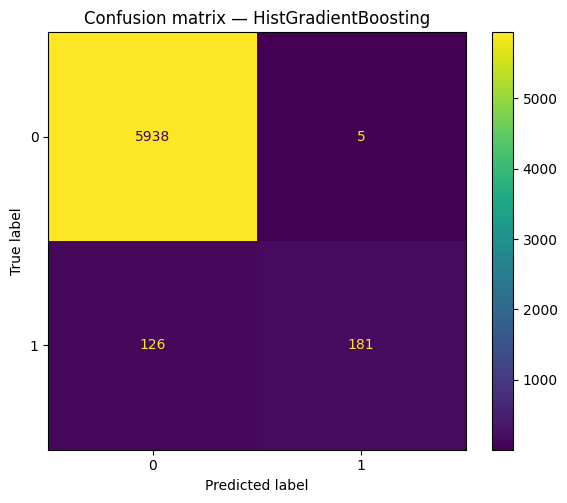

Saved: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW06\artifacts\figures\confusion_matrix__HistGradientBoosting.png


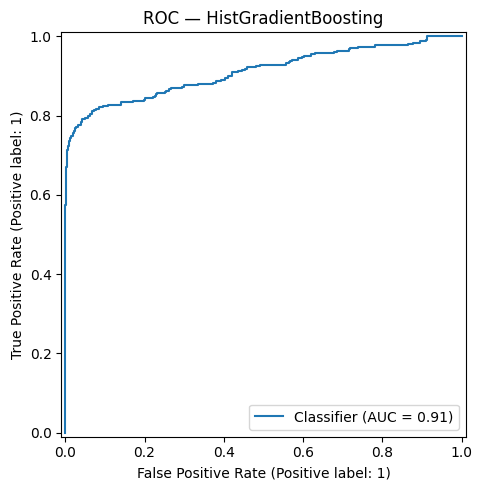

Saved: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW06\artifacts\figures\roc__HistGradientBoosting.png


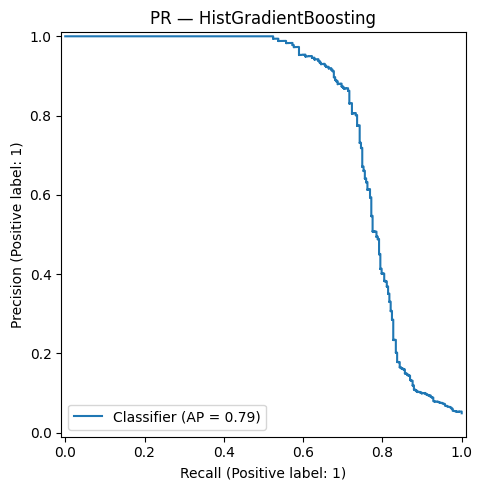

Saved: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW06\artifacts\figures\pr__HistGradientBoosting.png


In [15]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, ax=ax, values_format="d")
ax.set_title(f"Confusion matrix — {best_model_name}")
fig.tight_layout()
cm_path = FIGURES_DIR / f"confusion_matrix__{best_model_name}.png"
fig.savefig(cm_path, dpi=150)
plt.show()
print("Saved:", cm_path)

# ROC/PR только для бинарной и при наличии proba
if is_binary(y_test) and hasattr(best_model, "predict_proba"):
    y_score = best_model.predict_proba(X_test)[:, 1]

    fig, ax = plt.subplots(figsize=(6, 5))
    RocCurveDisplay.from_predictions(y_test, y_score, ax=ax)
    ax.set_title(f"ROC — {best_model_name}")
    fig.tight_layout()
    roc_path = FIGURES_DIR / f"roc__{best_model_name}.png"
    fig.savefig(roc_path, dpi=150)
    plt.show()
    print("Saved:", roc_path)

    fig, ax = plt.subplots(figsize=(6, 5))
    PrecisionRecallDisplay.from_predictions(y_test, y_score, ax=ax)
    ax.set_title(f"PR — {best_model_name}")
    fig.tight_layout()
    pr_path = FIGURES_DIR / f"pr__{best_model_name}.png"
    fig.savefig(pr_path, dpi=150)
    plt.show()
    print("Saved:", pr_path)
else:
    print("ROC/PR пропущены (не бинарная задача или нет predict_proba).")

,feature,importance_mean,importance_std
53,f54,0.036392,0.004137
24,f25,0.019454,0.003084
57,f58,0.015440,0.004616
32,f33,0.011129,0.002679
3,f04,0.009674,0.002964
52,f53,0.009609,0.004825
37,f38,0.008756,0.003948
46,f47,0.007839,0.004237
42,f43,0.005168,0.001802
10,f11,0.003977,0.001818


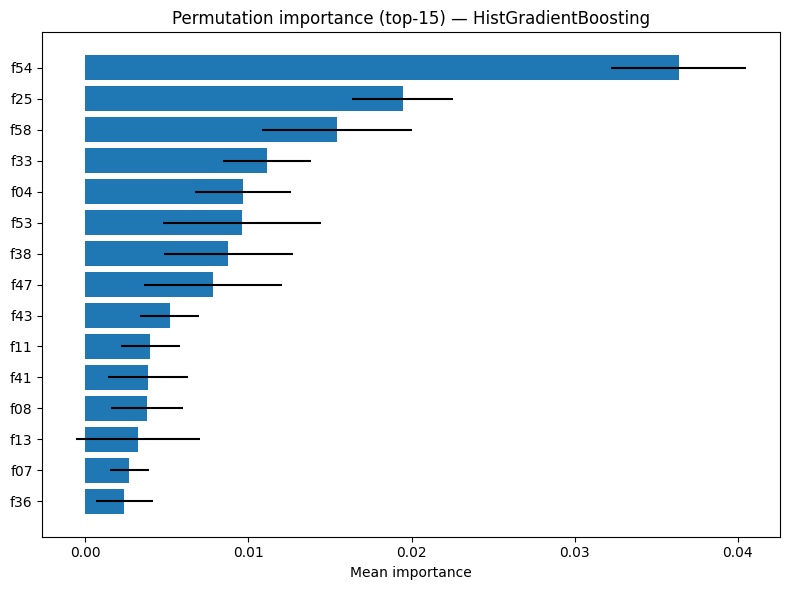

Saved: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW06\artifacts\figures\permutation_importance__HistGradientBoosting.png


In [16]:
winner_metric = "roc_auc" if is_binary(y_test) else "f1_macro"

# feature names после препроцессинга
try:
    feature_names = best_model.named_steps["preprocess"].get_feature_names_out()
except Exception:
    feature_names = None

perm = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring=winner_metric if winner_metric in ("roc_auc", "f1_macro") else None
)

imp_mean = perm.importances_mean
imp_std = perm.importances_std

if feature_names is None:
    feature_names = np.array([f"f{i}" for i in range(len(imp_mean))])

imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance_mean": imp_mean,
    "importance_std": imp_std
}).sort_values("importance_mean", ascending=False)

top_n = 15
display(imp_df.head(top_n))

# plot
top = imp_df.head(top_n).iloc[::-1]
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(top["feature"], top["importance_mean"], xerr=top["importance_std"])
ax.set_title(f"Permutation importance (top-{top_n}) — {best_model_name}")
ax.set_xlabel("Mean importance")
fig.tight_layout()
imp_path = FIGURES_DIR / f"permutation_importance__{best_model_name}.png"
fig.savefig(imp_path, dpi=150)
plt.show()
print("Saved:", imp_path)

In [17]:
metrics_path = ARTIFACTS_DIR / "metrics_test.json"
cv_path = ARTIFACTS_DIR / "cv_summary.json"
summaries_path = ARTIFACTS_DIR / "search_summaries.json"
model_path = ARTIFACTS_DIR / "best_model.joblib"
meta_path = ARTIFACTS_DIR / "best_model_meta.json"

# test-метрики всех моделей
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(metrics_test, f, ensure_ascii=False, indent=2)

# CV summary (важно: доказательство что выбирали по train-CV)
with open(cv_path, "w", encoding="utf-8") as f:
    json.dump(cv_summary, f, ensure_ascii=False, indent=2)

search_summaries = {
    "DecisionTree": {"best_params": dt_search.best_params_, "best_cv_score": float(dt_search.best_score_), "scoring": primary_scoring},
    "RandomForest": {"best_params": rf_search.best_params_, "best_cv_score": float(rf_search.best_score_), "scoring": primary_scoring},
    "HistGradientBoosting": {"best_params": hgb_search.best_params_, "best_cv_score": float(hgb_search.best_score_), "scoring": primary_scoring},
}
with open(summaries_path, "w", encoding="utf-8") as f:
    json.dump(search_summaries, f, ensure_ascii=False, indent=2)

joblib.dump(best_model, model_path)

meta = {
    "timestamp_utc": datetime.now(timezone.utc).isoformat(),
    "dataset_file": DATA_PATH.name,
    "selection_rule": "winner selected by CV on TRAIN only; TEST used only for final evaluation",
    "primary_scoring": primary_scoring,
    "cv_folds": cv.get_n_splits(),
    "cv_summary": cv_summary,
    "best_model_name": best_model_name,
    "best_model_test_metrics": best_test_metrics,
    "random_state": RANDOM_STATE,
    "test_size": TEST_SIZE,
}
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("Saved:", metrics_path)
print("Saved:", cv_path)
print("Saved:", summaries_path)
print("Saved:", model_path)
print("Saved:", meta_path)

Saved: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW06\artifacts\metrics_test.json
Saved: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW06\artifacts\cv_summary.json
Saved: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW06\artifacts\search_summaries.json
Saved: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW06\artifacts\best_model.joblib
Saved: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW06\artifacts\best_model_meta.json


## Итоги

- Выбор победителя выполнен строго по CV на train (см. artifacts/cv_summary.json).
- Тест использован только для финальной оценки и визуализаций.
- Для DecisionTree добавлен явный контроль сложности (max_depth/min_samples_split/min_samples_leaf/max_leaf_nodes/ccp_alpha).